In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.multiplex_utils import multiplex_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20201206_transfer_decidua"
MODEL_DIR = os.path.join("/data/analyses", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
import xarray as xr
data_dir = '/data/shirley/cohort/20200611_cohort/'
input_data = xr.open_dataarray('/data/shirley/cohort/deepcell_input.xr')

In [4]:
starts = [fov.split('_')[0] for fov in input_data.fovs.values]
keep = np.isin(starts, ['6', '8', '18', '20'])

In [5]:
input_data = input_data[keep]

In [6]:
processed = multiplex_preprocess(input_data)

In [7]:
from deepcell.model_zoo.panopticnet import PanopticNet

model_6 = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 6),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1,1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True,
    use_imagenet=False)
model_6.load_weights(MODEL_DIR + '/20200603_Decidua_with_old_256x256_deep_watershed_4_heads.h5')

W1216 17:41:48.912248 139772350863168 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
from deepcell.applications import MultiplexSegmentation
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell_toolbox.deep_watershed import deep_watershed_mibi

app = MultiplexSegmentation(use_pretrained_weights=False)
labeled_images = np.zeros((processed.shape[0], 2048, 2048, 1))
for i in range(processed.shape[0]):
    
    tiled_data, tile_info = tile_image(processed[i:(i +1), ...], model_input_shape=(256, 256), stride_ratio=1)
    model_output = model_6.predict(tiled_data)
    inner_distance, _, _, pixelwise = app._untile_output(model_output, tile_info)
    labels = deep_watershed_mibi({'inner-distance':inner_distance,
                                  'pixelwise-interior': pixelwise[..., 1:2]},
                                  maxima_threshold=0.05, maxima_model_smooth=0,
                                  interior_threshold=0.3,
                                  interior_model_smooth=1,
                                  radius=3,
                                  small_objects_threshold=10,
                                  fill_holes_threshold=10,)
    labeled_images[i, ...] = labels

In [23]:
import xarray as xr
segmentation_labels = xr.DataArray(labeled_images,
                         coords=[input_data.coords['fovs'], range(input_data.shape[1]), 
                                 range(input_data.shape[2]), 
                                 ['whole_cell']],
                         dims=['fovs', 'rows', 'cols', 'compartments'])
segmentation_labels.to_netcdf(os.path.join(MODEL_DIR, "segmentation_labels.xr"), format="NETCDF3_64BIT")

In [26]:
input_data.to_netcdf(os.path.join(MODEL_DIR, 'deepcell_input_truncated.xr'), format="NETCDF3_64BIT")

In [13]:
selected_fovs = ['6_31725_8_2', '6_31725_15_1', '6_31726_8_7',  '6_31727_15_3', '6_31728_15_6',
                    '16_31762_20_9',  '16_31765_19_1', '16_31775_5_1', '18_31782_5_7',  '18_31783_5_11']

selected_indices = np.where(np.isin(input_data.fovs.values, selected_fovs))[0]

In [4]:
new_fov = ['12_31728_1_8', '16_31767_3_3']

new_indices = np.where(np.isin(input_data.fovs.values, new_fov))[0]

In [8]:
np.sort(input_data.fovs.values)

array(['10_31739_6_13', '10_31739_6_14', '10_31739_6_15', '10_31739_6_16',
       '10_31740_16_6', '10_31740_6_11', '10_31740_6_12', '10_31741_1_1',
       '10_31742_1_2', '10_31743_16_7', '10_31743_16_8', '10_31744_1_3',
       '10_31745_16_10', '10_31745_16_9', '10_31745_1_4', '10_31745_1_5',
       '10_31745_1_6', '10_31747_1_7', '12_31748_1_8', '12_31749_16_11',
       '12_31749_1_9', '12_31750_16_12', '12_31750_1_10', '12_31750_1_11',
       '12_31751_1_12', '12_31752_1_13', '12_31754_16_13',
       '12_31754_16_14', '12_31754_16_15', '12_31754_18_2',
       '12_31754_1_14', '12_31754_1_15', '12_31754_1_16', '14_31755_18_1',
       '14_31755_20_1', '14_31756_16_16', '14_31756_20_2',
       '14_31757_20_3', '14_31758_16_17', '14_31758_20_4',
       '14_31758_20_5', '14_31759_16_18', '14_31759_20_6',
       '14_31760_16_19', '14_31761_16_20', '14_31761_20_7',
       '16_31762_16_21', '16_31762_20_8', '16_31762_20_9',
       '16_31763_20_10', '16_31765_19_1', '16_31765_20_11',
      

In [5]:
data_dir = '/data/shirley/cohort/20210103_comparison'

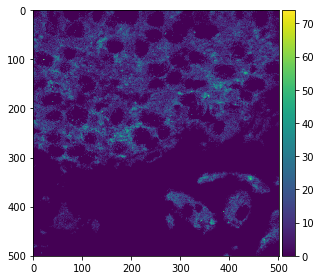

In [6]:
import skimage.io as io
io.imshow(input_data.loc['18_31785_5_13', :500, 1500:2000, 'HLAG'].values)

In [6]:
import skimage.io as io
for i in new_indices:
    current_fov = input_data.fovs.values[i]
    fov_folder = os.path.join(data_dir, current_fov)
    if not os.path.exists(fov_folder):
        os.makedirs(fov_folder)
    for j in range(6):
        current_img = input_data.channels.values[j]
        io.imsave(os.path.join(fov_folder, current_img + '.tiff'), input_data[i, :, :, j].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: /data/shirley/cohort/20210103_comparison/16_31767_3_3/H3.tiff is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: /data/shirley/cohort/20210103_comparison/16_31767_3_3/VIM.tiff is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: /data/shirley/cohort/20210103_comparison/16_31767_3_3/HLAG.tiff is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: /data/shirley/cohort/20210103_comparison/16_31767_3_3/CD3.tiff is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: /data/shirley/cohort/20210103_comparison/16_31767_3_3/CD14.tiff is a low contrast image
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-pack

In [7]:
new_indices

array([86])

In [17]:
# save segmentations
import skimage.io as io
for i in range(10):
    current_fov = input_data.fovs.values[i]
    fov_folder = os.path.join(data_dir, current_fov)
    io.imsave(os.path.join(fov_folder, 'segmentation_6_channel.tiff'), labeled_images[i, :, :, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirley/cohort/20200611_cohort/12_31750_16_12/segmentation_6_channel.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirley/cohort/20200611_cohort/16_31772_4_4/segmentation_6_channel.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirley/cohort/20200611_cohort/6_31731_11_6/segmentation_6_channel.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirley/cohort/20200611_cohort/6_31726_8_8/segmentation_6_channel.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirley/cohort/20200611_cohort/6_31727_8_10/segmentation_6_channel.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: /data/shirle

In [5]:
import skimage.io as io
for fov in ['6_31725_8_2', '18_31785_5_13']:
    fov_folder = os.path.join(data_dir, fov)
    if not os.path.exists(fov_folder):
        os.makedirs(fov_folder)
    for j in range(6):
        current_img = input_data.channels.values[j]
        io.imsave(os.path.join(fov_folder, current_img + '.tiff'), input_data.loc[fov, :, :, current_img].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: /data/shirley/cohort/20200611_cohort/6_31725_8_2/H3.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: /data/shirley/cohort/20200611_cohort/6_31725_8_2/VIM.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: /data/shirley/cohort/20200611_cohort/6_31725_8_2/HLAG.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: /data/shirley/cohort/20200611_cohort/6_31725_8_2/CD3.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: /data/shirley/cohort/20200611_cohort/6_31725_8_2/CD14.tiff is a low contrast image
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: /data/shirley/cohort/20200611_cohort/6_31725_8_2/CD56.tiff is a low contrast image
  
/usr/local/lib/python3.6/d

In [16]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries[..., 0] > 0, :] = 1
    
    return overlay_data

In [17]:
rgb_data = make_color_overlay(processed[:25, ..., :3])

In [18]:
overlays = make_outline_overlay(rgb_data[:25], labeled_images[:25])

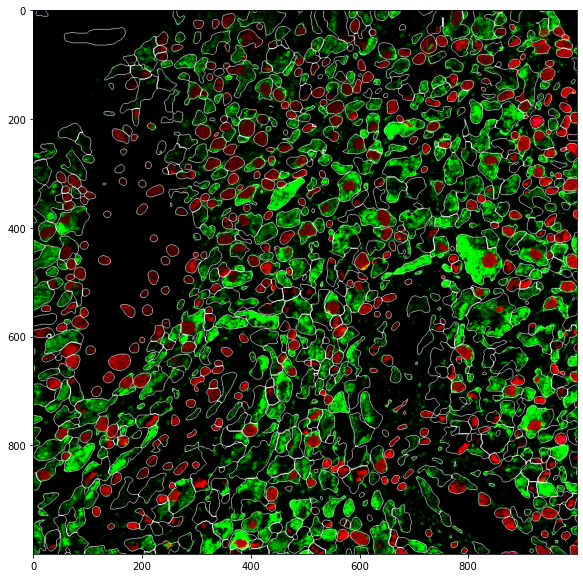

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(overlays[4, :1000, :1000, :])